# Time series - analysis by decomposition

In this example, we'll explore parts of classical time series analysis and fit a simple regressive model.

In [2]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_rows = 10
matplotlib.rcParams['figure.figsize'] = (15, 6)

We'll use the well-known air passengers time series for this example. 

First, let's download sample dataset directly from the mlcollege github account.

Notice the date parsing function that allows us to build an index on this time series.

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/mlcollege/time-series-analysis-v2/master/data/AirPassengers.csv', 
                   parse_dates=True, index_col='Month', date_parser=lambda x: datetime.strptime(x, '%Y-%m'))
ts = data['#Passengers']
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Now let's see how the time series looks like. 


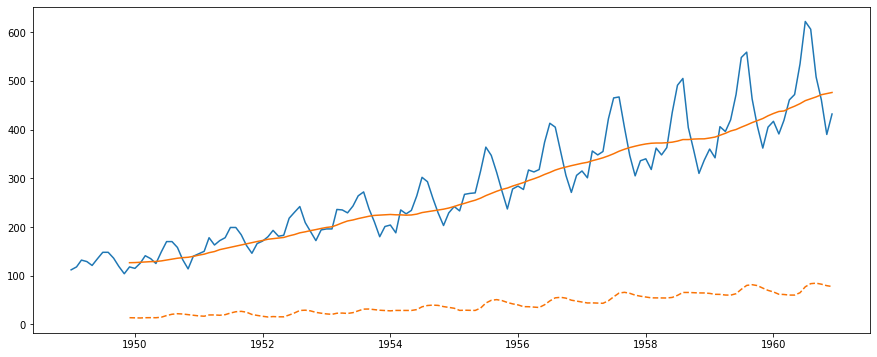

In [6]:
rolling = ts.rolling(center=False, window=12)        
plt.plot(ts)
plt.plot(rolling.mean(), color="xkcd:orange")
plt.plot(rolling.std(),  color="xkcd:orange", linestyle="--")
plt.show()

When we look at the data we generally want to understand the underlying process that generates such observations. The usual process is to identify various components and "explain them away". 

When all identifiable components are explained, we usually say that the rest is just random noise (there's not many other choices anyway)

When we look at the time series above, we can observe several components:

- **frequency** -- there's one sample per month
- **inflation** -- standard deviation is not constant in time
- **trend** -- mean is not constant in time
- **seasonality** -- there's a strong yearly pattern


## Inflation adjustment -- deflation

Monetary time series often contains an *inflation component* which affects the variance of the time series over time. To stabilize variance, one need to "deflate" the time series by dividing it by a specific index (for example the Consumer Price Index - CPI). 

There are many indices for various industry types you can select from but there's another way how to deflate a time series -- *natural logarithm*.

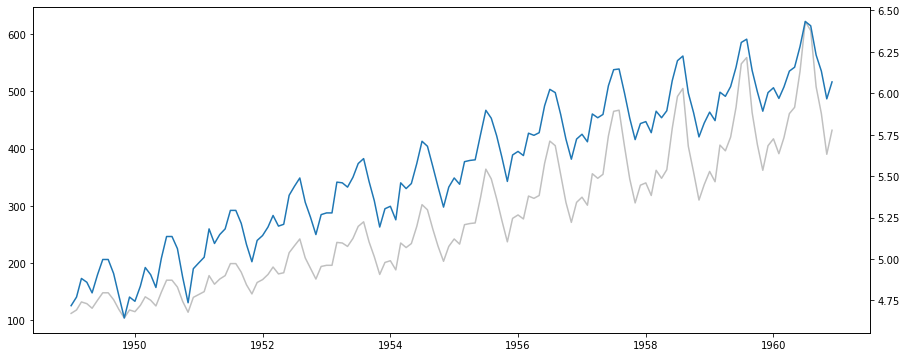

In [10]:
log_ts = np.log(ts)

plt.plot(ts, c='silver')
plt.twinx()
plt.plot(log_ts)
plt.show()

## Seasonal decomposition



Next, we can try *seasonal_decompose* library function that can perform trend & seasonality decomposion.

*Note: Look at [this notebook](https://notebook.community/jrmontag/Data-Science-45min-Intros/time-series/03%20-%20Seasonal-Trend%20Decomposition) for explanation how `seasonal_decompose` in `stats_models` works*

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_decomposition(original, decomposition):    
    plt.figure(figsize=(15, 10))    
    plt.subplot(211)    
    plt.plot(original, label='Original')
    plt.plot(decomposition.trend, label='Trend')    
    plt.legend(loc='upper left')
    plt.subplot(212)
    plt.plot(decomposition.seasonal, label='Seasonality', color="xkcd:orange")    
    plt.plot(decomposition.resid, label='Residuals', color="xkcd:black")    
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

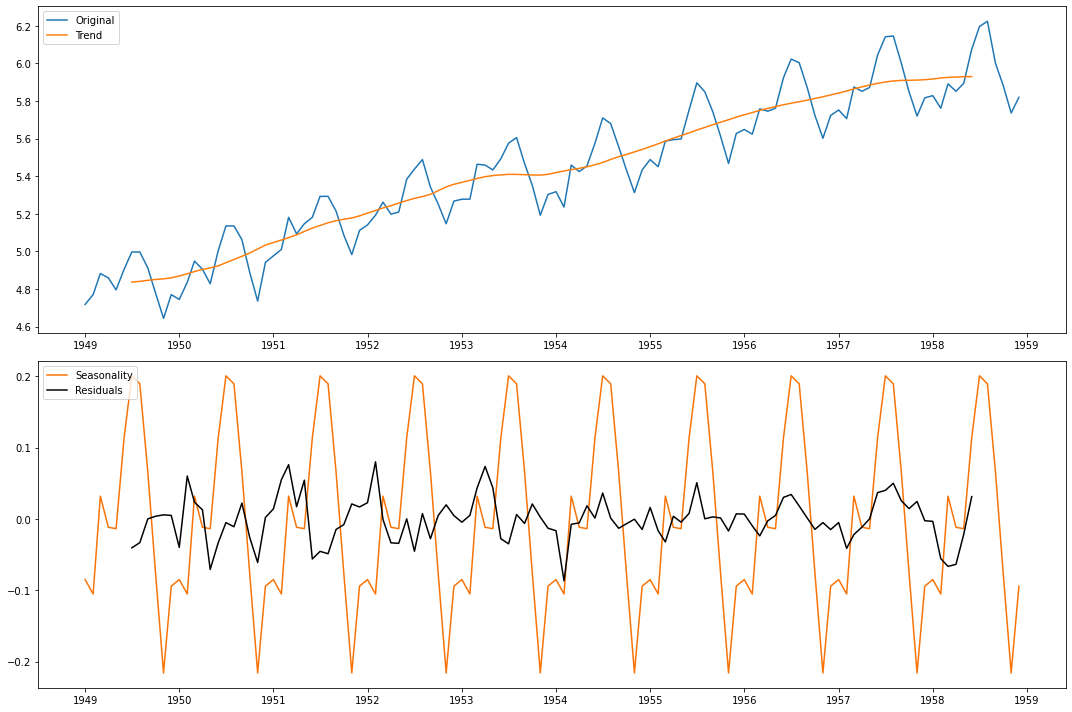

In [22]:
decomposition = seasonal_decompose(log_ts)
plot_decomposition(log_ts, decomposition)

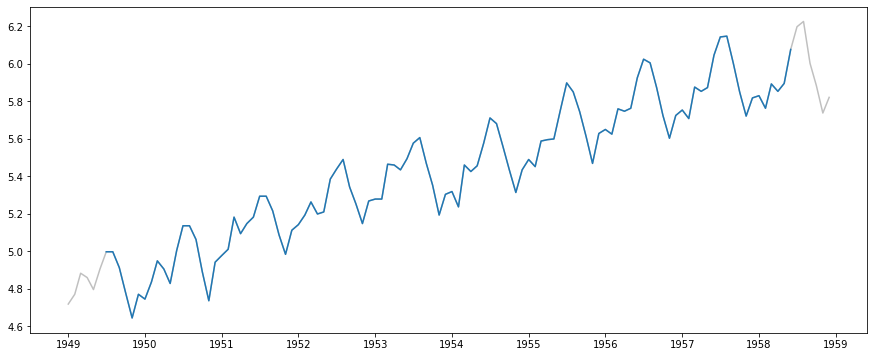

In [23]:
plt.plot(log_ts, color="silver")
plt.plot(decomposition.seasonal + decomposition.resid + decomposition.trend)    

In [24]:
print(decomposition.resid.mean())
print(decomposition.resid.std())

-0.0011080784509196724
0.03139715422865187


## Forecasting from decomposition

We now have the time series decomposed into components. The residual from decomposion does not look like anything else then noise with 0 mean.

The next natural step is to ask whether we can **use the decomposition to forecast** the future with assumption that the parts we explained will not change significantly.

But first, we should think about **testing the model** we are up to build. We indeed can take the data and just extrapolate the end for a year or two but then we have blindly trust the model we built.

Better approach would be to create a **validation set**, a standard technique used in ML everywhere.

For time series, we can trim the data at the end and use it as a validation set.

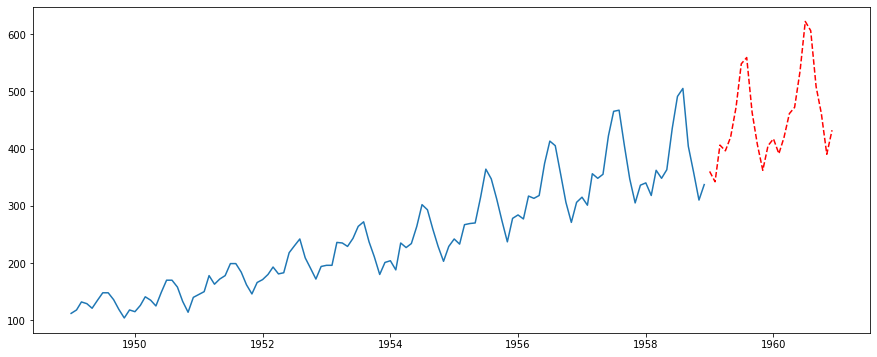

In [25]:
# let's take 2 years of data as a validation set
VALIDATION_MARK = 24

training_ts = ts[:-VALIDATION_MARK]
validation_ts = ts[-VALIDATION_MARK:]

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.show()

Now, let's **decompose the time series again** to not use validation data for forecasting

In [26]:
log_ts = np.log(training_ts)
decomposition = seasonal_decompose(log_ts)

### Forecasting trend

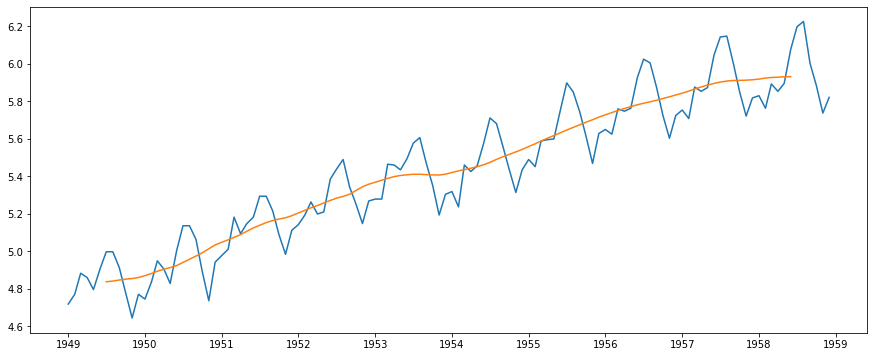

In [28]:
plt.plot(log_ts)
plt.plot(decomposition.trend)
plt.show()

We can approximate trend with simple linear regression (once the series is deflated with log. function).

There are many other approaches to extrapolate trend, but for simplicity, let's stay with this one.

In [34]:
from sklearn.linear_model import LinearRegression

def predict_trend(inputs):
    X = inputs.index.to_julian_date()
    X = np.expand_dims(X, -1)
    Y = inputs

    reg = LinearRegression().fit(X, Y)

    forecast_ts_index=pd.pandas.date_range(start=log_ts.index[0], periods=len(log_ts) + VALIDATION_MARK, freq='MS')
    x = np.expand_dims(forecast_ts_index.to_julian_date(), -1)

    return pd.Series(reg.predict(x), index=forecast_ts_index)

See the shape of the input data (2D tensor, multiple regressors are possible but not used here)

Now, let's prepare a new date range (with extra two years for prediction) and extrapolate trend:

In [37]:
forecast_trend = predict_trend(log_ts)

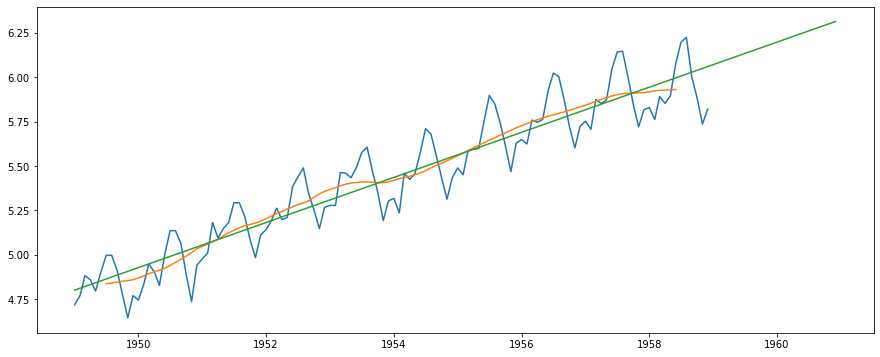

In [40]:
plt.plot(log_ts)
plt.plot(decomposition.trend)
plt.plot(forecast_trend)
plt.show()

### Forecasting seasonality

Next, we simply take the last year of seasonal component and use it as a forecasted seasonal effect.

In [41]:
season = decomposition.seasonal.values[-12:]
forecast_season = np.concatenate((decomposition.seasonal.values, season, season))

deflated_forecast = forecast_trend + forecast_season

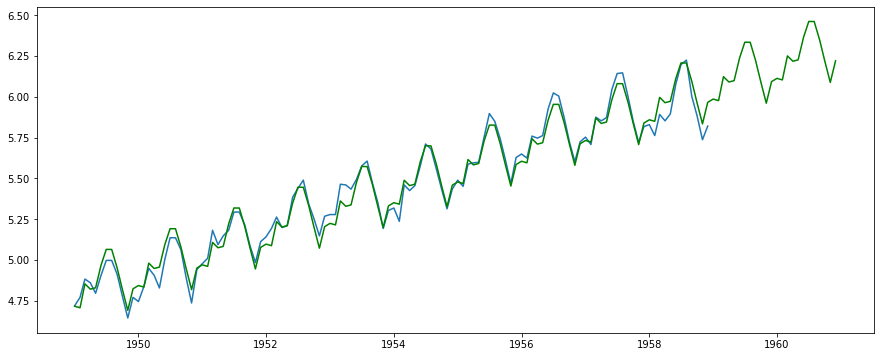

In [42]:
plt.plot(log_ts)
plt.plot(deflated_forecast, color='g')
plt.show()

Last, we need to inflate the series again to return it into the correct # passengers domain.

In [43]:
complete_forecast = np.exp(forecast_trend + forecast_season)

Finally, let's see how the forecast performs against the training and validation set. The simple squared error should be enough for future comparison.

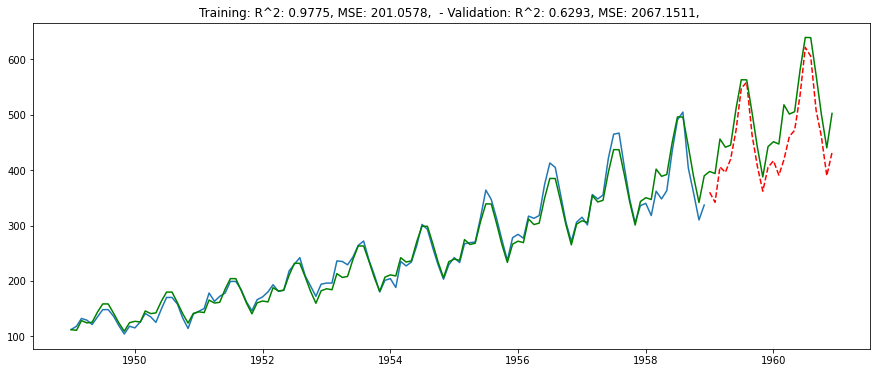

In [44]:
from sklearn.metrics import r2_score, mean_squared_error

plt.plot(training_ts)
plt.plot(validation_ts, 'r--')
plt.plot(complete_forecast, 'g')

def get_metrics(*args):
    return (
        f'R^2: {r2_score(*args):.4f}, ' +        
        f'MSE: {mean_squared_error(*args):.4f}, '        
    )

t_m = get_metrics(training_ts.values, complete_forecast.values[:-VALIDATION_MARK])
v_m = get_metrics(validation_ts.values, complete_forecast.values[-VALIDATION_MARK:])

plt.title(f'Training: {t_m} - Validation: {v_m}')

plt.show()